<a href="https://colab.research.google.com/github/takakishi/HEC_DS_ML_project/blob/main/src/BERT4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install additionnal packages

In [ ]:
!pip install bert-tensorflow
!pip install spacy-transformers
!python -m spacy download fr_dep_news_trf
!pip install tensorflow_text
!pip install sentencepiece
!pip install sacremoses
!pip install pyphen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 10.3 MB/s eta 0:00:00
2023-12-13 12:59:22.086390: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 12:59:22.086453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 12:59:22.086494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 12:59:22.094532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized 

#Set the test size
First, use 0.3 to train the first three NN, we then use their predictions to train the fourth NN, where the test size is 0.2. When all the models are trained, re-train the first three models with test size 0.01.

In [ ]:
test_size = 0.3

#Imports

## Import Libraries

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
import spacy
import spacy_transformers
import torch
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

##Import data

In [ ]:
# Import Data
sample_submission = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/sample_submission.csv')
training_data = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/training_data.csv')
unlabelled_test_data = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/unlabelled_test_data.csv')

Use onehot encoder on the text difficulty labels

#Neural Networks:
In total, 4 Neural Networks are used. One neural network with readability features. One Neural Network with CamemBert embeddings. One Neural Network with Frequency features, namely TF-IDF. The last Neural Network model takes the predictions of the first 3 as input.

##Build the NN for the readability feature

###Labels with OneHot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder_hot = OneHotEncoder()

encoder_hot.fit(training_data[['difficulty']])
onehot = encoder_hot.transform(training_data[['difficulty']]).toarray()
y_onehot = onehot

###Readability feature


Function count_syllables that count the syllables within a word

In [ ]:
import pyphen

dic = pyphen.Pyphen(lang='fr_FR')

def count_syllables(word):
    # Use the pyphen library to count syllables
    return max(1, len(dic.positions(word)) + 1)

Using a spaCY French language model, extract different readability feature from the dataset. A new dataframe is then created, with the following columns name: avg_sentence_length 	avg_word_length 	num_noun 	num_adj 	num_adv 	num_adp 	num_pron 	num_det 	num_verb 	avg_syllables_per_word 	num_words_1_to_3_syllables 	num_words_4_syllables 	num_long_words

In [ ]:
nlp = spacy.load("fr_dep_news_trf")

def analyze_text(df):
    # Tokenize and analyze each text in the DataFrame
    df['doc'] = df['sentence'].apply(lambda text: nlp(text))

    # Create a list of tokens without stopwords for each document
    df['tokens_without_stopwords'] = df['doc'].apply(lambda doc: [token.text for token in doc if not token.is_stop and not token.is_punct])

    # Calculate the average sentence length per observation
    df['avg_sentence_length'] = df['doc'].apply(lambda doc: sum(len(sent) for sent in list(doc.sents)) / len(list(doc.sents)))

    df['number_of_sentences'] = df['doc'].apply(lambda doc: len(list(doc.sents)))

    # Add features for various parts of speech
    pos_tags = ['NOUN', 'ADJ', 'ADV', 'ADP', 'PRON', 'DET', 'VERB']

    for pos_tag in pos_tags:
        df[f'num_{pos_tag.lower()}'] = df['doc'].apply(lambda doc: len([token for token in doc if token.pos_ == pos_tag]))

    # Calculate the average word length per observation (excluding stopwords)
    df['avg_word_length'] = df['tokens_without_stopwords'].apply(lambda tokens: sum(len(token) for token in tokens) / len(tokens) if tokens else 0)

    # Calculate the average syllable count per word (excluding stopwords)
    df['avg_syllables_per_word'] = df['tokens_without_stopwords'].apply(lambda tokens: sum(count_syllables(token) for token in tokens) / len(tokens) if tokens else 0)

    # Count the number of words with 1 to 3 syllables (excluding stopwords)
    df['num_words_1_to_3_syllables'] = df['tokens_without_stopwords'].apply(lambda tokens: len([token for token in tokens if 1 <= count_syllables(token) <= 3]))

    # Count the number of words with 4 syllables (excluding stopwords)
    df['num_words_4_syllables'] = df['tokens_without_stopwords'].apply(lambda tokens: len([token for token in tokens if count_syllables(token) == 4]))

    # Set a threshold for long words (customize as needed)
    long_word_threshold = 10

    # Calculate the number of long words per observation (excluding stopwords)
    df['num_long_words'] = df['tokens_without_stopwords'].apply(lambda tokens: len([token for token in tokens if len(token) >= long_word_threshold]))


    for pos_tag in pos_tags:
        df[f'num_{pos_tag.lower()}'] /= df['number_of_sentences']

    df['num_words_1_to_3_syllables'] /= df['number_of_sentences']
    df['num_words_4_syllables'] /= df['number_of_sentences']
    df['num_long_words'] /= df['number_of_sentences']

    # Return the DataFrame with added columns
    return df[['avg_sentence_length', 'avg_word_length', *['num_' + pos.lower() for pos in pos_tags],
               'avg_syllables_per_word', 'num_words_1_to_3_syllables', 'num_words_4_syllables', 'num_long_words']]

# Example usage:
result_df = analyze_text(training_data)

In [ ]:
result_df_final = analyze_text(unlabelled_test_data)

###Create the NN model

In [ ]:
num_features = result_df.shape[1]
def build_feature_model():
  feature_input = tf.keras.layers.Input(shape=(num_features,), dtype=tf.float32, name='feature_input')
  feature_net = feature_input
  feature_net = tf.keras.layers.BatchNormalization()(feature_net)
  feature_net = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='hidden_1_classifier')(feature_net)
  feature_net = tf.keras.layers.Dropout(0.1)(feature_net)
  feature_net = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='hidden_2_classifier')(feature_net)
  feature_net = tf.keras.layers.Dropout(0.1)(feature_net)
  feature_net = tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='feature_classifier')(feature_net)

  # Create the model
  model = tf.keras.Model(inputs=feature_input, outputs=feature_net)

  return model

NameError: ignored

###Set the different parameters

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

classifier_feature_model = build_feature_model()
tf.keras.utils.plot_model(classifier_feature_model)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()
init_lr = 3e-5
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=init_lr)
classifier_feature_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

###Spilt the data between train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
result_df_train, result_df_test, y_onehot_train, y_onehot_test = train_test_split(result_df, y_onehot, test_size=test_size, random_state=42)

_, _, _, y_test = train_test_split(result_df, training_data['difficulty'], test_size=test_size, random_state=42)

###Train the model

In [ ]:
classifier_feature_model.fit(result_df_train, y_onehot_train, epochs=100, batch_size=16, validation_data=(result_df_test, y_onehot_test)) #210

NameError: ignored

###Plot a confusion matrix for performance analysis

45/45 [==============================] - 0s 2ms/step


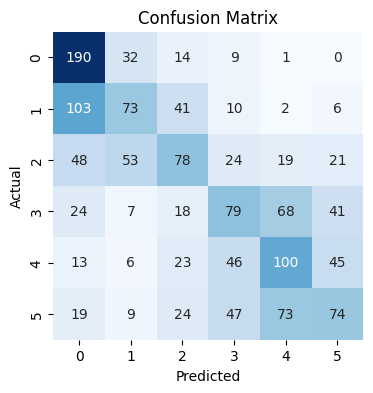

In [ ]:
y_pred = classifier_feature_model.predict(result_df_test)

y_pred = np.argmax(y_pred, axis=1)
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
y_pred = [label_mapping[idx] for idx in y_pred]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Build the NN for text embeddings, with CamemBert pre-trained model

###Note
The following code was inspired by this : https://colab.research.google.com/github/Ankur3107/colab_notebooks/blob/master/classification/BERT_Fine_Tuning_Sentence_Classification_v2.ipynb#scrollTo=6ulTWaOr8QNY

Train the model on GPU instead of CPU

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


Prepare the data. Sentences as input, and labels as output.

In [ ]:
sentences = training_data.sentence.values
labels = training_data.difficulty.values

###Load CamembertTokenizer

In [ ]:
from transformers import CamembertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

Loading BERT tokenizer...


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Les coûts kilométriques réels peuvent diverger sensiblement des valeurs moyennes en fonction du moyen de transport utilisé, du taux d'occupation ou du taux de remplissage, de l'infrastructure utilisée, de la topographie des lignes, du flux de trafic, etc.
Tokenized:  ['▁Les', '▁coûts', '▁kilo', 'métrique', 's', '▁réels', '▁peuvent', '▁d', 'iver', 'ger', '▁sensiblement', '▁des', '▁valeurs', '▁moyennes', '▁en', '▁fonction', '▁du', '▁moyen', '▁de', '▁transport', '▁utilisé', ',', '▁du', '▁taux', '▁d', "'", 'occupation', '▁ou', '▁du', '▁taux', '▁de', '▁remplissage', ',', '▁de', '▁l', "'", 'infrastructure', '▁utilisée', ',', '▁de', '▁la', '▁top', 'ographie', '▁des', '▁lignes', ',', '▁du', '▁flux', '▁de', '▁trafic', ',', '▁etc', '.']
Token IDs:  [74, 3945, 14174, 9306, 10, 9706, 316, 18, 13732, 2038, 17399, 20, 1784, 9446, 22, 594, 25, 694, 8, 1409, 1181, 7, 25, 1028, 18, 11, 9276, 47, 25, 1028, 8, 19838, 7, 8, 17, 11, 13471, 3144, 7, 8, 13, 1693, 4745, 20, 2015, 7, 25, 4278, 8, 3

###Pre-process (tokenize) the texts

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Les coûts kilométriques réels peuvent diverger sensiblement des valeurs moyennes en fonction du moyen de transport utilisé, du taux d'occupation ou du taux de remplissage, de l'infrastructure utilisée, de la topographie des lignes, du flux de trafic, etc.
Token IDs: [5, 74, 3945, 14174, 9306, 10, 9706, 316, 18, 13732, 2038, 17399, 20, 1784, 9446, 22, 594, 25, 694, 8, 1409, 1181, 7, 25, 1028, 18, 11, 9276, 47, 25, 1028, 8, 19838, 7, 8, 17, 11, 13471, 3144, 7, 8, 13, 1693, 4745, 20, 2015, 7, 25, 4278, 8, 3893, 7, 498, 9, 6]


Print the max sentence lenght in the sample

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  378


###Padding/truncating the sequence to a max length. Here max length is set to 250.

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 250 # best 250

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 250 values...

Padding token: "<pad>", ID: 1

Done.


###Create attention masks

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

###Labels with Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
labels = label_encoder.fit_transform(labels)

###Split the data between train and test set

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=test_size)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=test_size)

###Convert inputs and lables into torch tensors

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

###Import pretrained camemBert model

Namely CamembertForSequenceClassification, which was trained on french corpus

In [ ]:
from transformers import CamembertForSequenceClassification, AdamW

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.

model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weigh

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

###Set the different parameters

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4 # 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Function to calculate the accuracy of our predictions vs labels

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Function to calculate the time it takes to run the code

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

###Train the model

In [1]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

NameError: ignored

###Make the predictions
Which will be used to train the final NN model. We predict the labels of the the test set.

In [ ]:
import pandas as pd
_, sentences, _, _ = train_test_split(training_data.sentence.values, labels, random_state=42, test_size=test_size)
# Report the number of sentences.
# print('Number of test sentences: {:,}\n'.format(unlabelled_test_data.shape[0])) !!!!!!!!!!!!!!!!!!
#print('Number of test sentences: {:,}\n'.format(training_data.shape[0]))
print('Number of test sentences: {:,}\n'.format(sentences.shape[0]))
# Create sentence and label lists
#sentences = unlabelled_test_data.sentence.values  ######## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#sentences = training_data.sentence.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
#prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,440



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions = []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Predicting labels for 1,440 test sentences...
    DONE.


###Plot confusion matrix for performance analysis

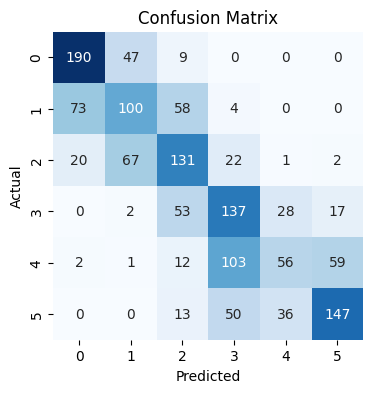

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
y_pred = flat_predictions
y_pred = np.argmax(y_pred, axis=1).flatten()
y_pred = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

convert the prediction format to match the onehot encoding format

In [ ]:
probs_list = [np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True) for logits in flat_predictions]

##Build the NN for word frequency, with TF-IDF method

###Pre-process the data (TF-IDF)

Using spaCy, tokenize sentences in order to prepare the data to be used with TF-IDF

In [ ]:
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    #stop_words = spacy.lang.fr.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = nlp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens
                 if word not in punctuations ]) # word not in stop_words and

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

Apply spacy_tokenizer to the dataframes

In [ ]:
unlabelled_test_data['processed_sentence'] = unlabelled_test_data['sentence'].apply(spacy_tokenizer)
training_data['processed_sentence'] = training_data['sentence'].apply(spacy_tokenizer)
data_final = pd.concat([training_data[['processed_sentence']], unlabelled_test_data[['processed_sentence']]], ignore_index=True, axis=0)

###TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf_final = vectorizer.fit_transform([' '.join(doc) for doc in data_final['processed_sentence']])

# Convert sparse matrix to Pandas DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf_final.toarray(), columns=vectorizer.get_feature_names_out())

# Separate X_final and X_tfidf
X_final = X_tfidf_df.iloc[-1200:]
X_tfidf = X_tfidf_df.iloc[:-1200]

In [ ]:
num_additional_features = X_tfidf_df.shape[1]

###Create the NN model

In [ ]:
def build_tfidf_model():
  tfidf_input = tf.keras.layers.Input(shape=(num_additional_features,), dtype=tf.float32, name='tfidf_input')
  tfidf_net = tfidf_input
  tfidf_net = tf.keras.layers.BatchNormalization()(tfidf_net)
  tfidf_net = tf.keras.layers.Dropout(0.1)(tfidf_net)
  tfidf_net = tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='tfidf_classifier')(tfidf_net)

  # Create the model
  model = tf.keras.Model(inputs=tfidf_input, outputs=tfidf_net)

  return model

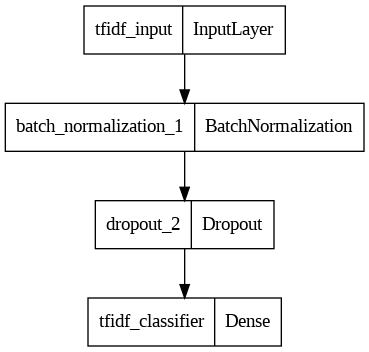

In [ ]:
classifier_tfidf_model = build_tfidf_model()
tf.keras.utils.plot_model(classifier_tfidf_model)

###Set the different parameters

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()
init_lr = 3e-5
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=init_lr)
classifier_tfidf_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

###Split the data between train and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_tfidf_train, X_tfidf_test, y_onehot_train, y_onehot_test = train_test_split(X_tfidf, y_onehot, test_size=test_size, random_state=42)

###Train the model

In [ ]:
classifier_tfidf_model.fit(X_tfidf_train, y_onehot_train, epochs=60, batch_size=16, validation_data=(X_tfidf_test, y_onehot_test)) # epoch = 20

Epoch 1/60
210/210 [==============================] - 2s 8ms/step - loss: 1.8904 - categorical_accuracy: 0.1836 - val_loss: 1.8684 - val_categorical_accuracy: 0.1722
Epoch 2/60
210/210 [==============================] - 1s 7ms/step - loss: 1.8461 - categorical_accuracy: 0.2295 - val_loss: 1.8459 - val_categorical_accuracy: 0.2000
Epoch 3/60
210/210 [==============================] - 1s 7ms/step - loss: 1.8134 - categorical_accuracy: 0.2827 - val_loss: 1.8195 - val_categorical_accuracy: 0.2229
Epoch 4/60
210/210 [==============================] - 1s 6ms/step - loss: 1.7869 - categorical_accuracy: 0.3176 - val_loss: 1.7962 - val_categorical_accuracy: 0.2389
Epoch 5/60
210/210 [==============================] - 1s 6ms/step - loss: 1.7630 - categorical_accuracy: 0.3586 - val_loss: 1.7751 - val_categorical_accuracy: 0.2542
Epoch 6/60
210/210 [==============================] - 2s 8ms/step - loss: 1.7412 - categorical_accuracy: 0.3878 - val_loss: 1.7547 - val_categorical_accuracy: 0.2722
Epoc

###Plot the confustion matrix for performance analysis

45/45 [==============================] - 0s 3ms/step


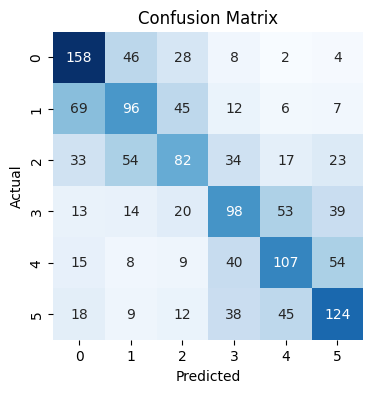

In [ ]:
y_pred = classifier_tfidf_model.predict(X_tfidf_test)

y_pred = np.argmax(y_pred, axis=1)
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
y_pred = [label_mapping[idx] for idx in y_pred]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Build the final NN for text difficulty predictions

Until now, we trained 3 NN. Now, we will use the test set to make predictions, which will be used to train our final NN, which takes as input the predictions from the past 3 NN. The idea behind this methodology is that each NN may captures different aspects of text difficulty. Thus, combining their predictions as input for an additionnal NN should enhance the performance.

###Prediction on the test set for the past 3 NN models

In [ ]:
y_bert = probs_list
y_tfidf = classifier_tfidf_model.predict(X_tfidf_test) # X_tfidf
y_feature = classifier_feature_model.predict(result_df_test)

75/75 [==============================] - 0s 1ms/step


###Give more weight to the best model.

Here, we filter the predictions, to avoid noise resulting from low probablities. The threshold are set lower for the best model, and higher for the less accurate models.

In [ ]:
y_bert = np.where(np.array(y_bert) > 0.3, np.array(y_bert), 0)
y_tfidf = np.where(y_tfidf > 0.4, y_tfidf, 0)
y_feature = np.where(y_feature > 0.5, y_feature, 0)

Concatenate the predictions, in order to use them as input for the final NN

In [ ]:
y_concat = np.concatenate((y_tfidf, y_bert, y_feature), axis=1)

###Split the data between train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
y_concat_train, y_concat_test, y_onehot_train, y_onehot_test = train_test_split(y_concat, y_onehot_test, test_size=0.1, random_state=42)

###Create the final NN model

In [ ]:
num_final_y = y_concat.shape[1]

def build_concat_model():
  concat_input = tf.keras.layers.Input(shape=(num_final_y,), dtype=tf.float32, name='concat_input')
  concat_net = concat_input
  concat_net = tf.keras.layers.BatchNormalization()(concat_net)
  concat_net = tf.keras.layers.Dropout(0.1)(concat_net)
  concat_net = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='hidden_3_classifier')(concat_net)
  concat_net = tf.keras.layers.Dropout(0.1)(concat_net)
  concat_net = tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='final_classifier')(concat_net)

  # Create the model
  model = tf.keras.Model(inputs=concat_input, outputs=concat_net)

  return model

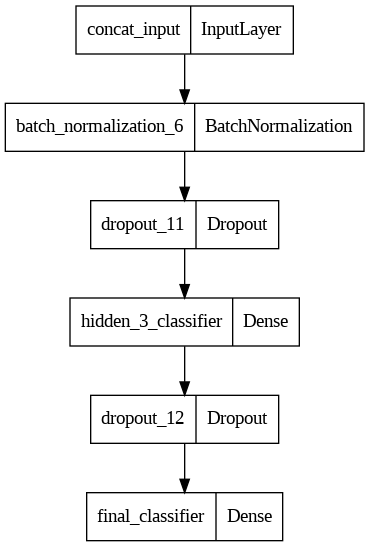

In [ ]:
classifier_concat_model = build_concat_model()
tf.keras.utils.plot_model(classifier_concat_model)

###Set the different parameters

In [ ]:
init_lr = 3e-5
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=init_lr)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()
classifier_concat_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

###Train the final model

In [ ]:
classifier_concat_model.fit(y_concat_train, y_onehot_train, epochs=100, batch_size=16, validation_data=(y_concat_test, y_onehot_test))

Epoch 1/100
135/135 [==============================] - 1s 3ms/step - loss: 2.2353 - categorical_accuracy: 0.1412 - val_loss: 2.1701 - val_categorical_accuracy: 0.1333
Epoch 2/100
135/135 [==============================] - 0s 2ms/step - loss: 2.1857 - categorical_accuracy: 0.1704 - val_loss: 2.1274 - val_categorical_accuracy: 0.2125
Epoch 3/100
135/135 [==============================] - 0s 2ms/step - loss: 2.1268 - categorical_accuracy: 0.2278 - val_loss: 2.0753 - val_categorical_accuracy: 0.2667
Epoch 4/100
135/135 [==============================] - 0s 2ms/step - loss: 2.0738 - categorical_accuracy: 0.2949 - val_loss: 2.0234 - val_categorical_accuracy: 0.3708
Epoch 5/100
135/135 [==============================] - 0s 2ms/step - loss: 2.0265 - categorical_accuracy: 0.3194 - val_loss: 1.9772 - val_categorical_accuracy: 0.3917
Epoch 6/100
135/135 [==============================] - 0s 2ms/step - loss: 1.9824 - categorical_accuracy: 0.3690 - val_loss: 1.9325 - val_categorical_accuracy: 0.391

###Plot the confusion matrix for performance analysis

8/8 [==============================] - 0s 1ms/step


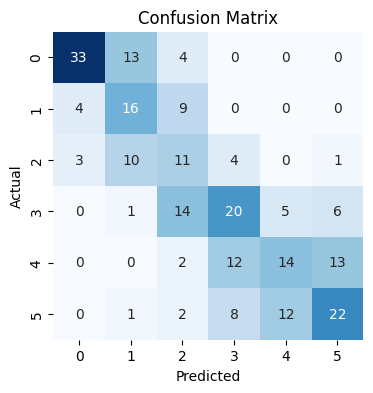

In [ ]:
_, _, _, y_test = train_test_split(training_data['sentence'], training_data['difficulty'], test_size=test_size, random_state=42)
_, _, _, y_test = train_test_split(y_concat, y_test, test_size=0.1, random_state=42)
y_pred = classifier_concat_model.predict(y_concat_test)

y_pred = np.argmax(y_pred, axis=1)
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
y_pred = [label_mapping[idx] for idx in y_pred]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Final predictions

Now the final model is trained. Now retrain, the initial 3 models, with a very small test size (0.01). The goal is to extract a maximum of information. Then final predicitions for the first 3 NN are performed. Then their predictions are concatenate, to be feeded as inputs into the final NN.

##CamemBert NN

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(unlabelled_test_data.shape[0]))

# Create sentence and label lists
sentences = unlabelled_test_data.sentence.values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
#prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,200



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions = []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Predicting labels for 1,200 test sentences...
    DONE.


Again, convert the prediction format to match the onehot encoding format. (Because the CamemBert NN use label encoding)

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
probs_list = [np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True) for logits in flat_predictions]

##TF-IDF and readability feature NN predictions

In [ ]:
y_bert_final = probs_list
y_tfidf_final = classifier_tfidf_model.predict(X_final) # X_final
y_feature_final = classifier_feature_model.predict(result_df_final)

38/38 [==============================] - 0s 1ms/step


Concatenante the predictions

In [ ]:
y_concat_final = np.concatenate((y_tfidf_final, y_bert_final, y_feature_final), axis=1)

##Predictions of the final NN

In [ ]:
y_final = classifier_concat_model.predict(y_concat_final)

38/38 [==============================] - 0s 1ms/step


##Prepare sample submission

###Translate the labels (A1,A2,...,C2)

In [ ]:
predicted_labels = np.argmax(y_final, axis=1)
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
translated_labels = [label_mapping[idx] for idx in predicted_labels]

In [ ]:
sample_submission['difficulty'] = translated_labels

###Download the sample submission as a .csv file

In [ ]:
csv_file_path = 'sample_submission_78.csv'

# Export the DataFrame to CSV
sample_submission.to_csv(csv_file_path, index=False)

In [ ]:
from google.colab import files

# Download the CSV file from Colab to your local machine
files.download("sample_submission_78.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Save the model and its weights

##Set the path to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib

joblib.dump(log_reg_length_basic, '/content/drive/My Drive/Colab Notebooks/log_reg_length_basic.joblib')
joblib.dump(log_reg_length_basic, '/content/drive/My Drive/Colab Notebooks/log_reg_length_basic.joblib')
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/Colab Notebooks/tfidf_vectorizer.joblib')
joblib.dump(scaler, '/content/drive/My Drive/Colab Notebooks/length_scaler.joblib')

MessageError: ignored

In [ ]:
import pickle

with open('/content/drive/MyDrive/model_ANN/model_tfidf.pkl', 'wb') as file:
    pickle.dump(classifier_tfidf_model, file)

In [ ]:
with open('/content/drive/MyDrive/model_ANN/model_feature.pkl', 'wb') as file:
    pickle.dump(classifier_feature_model, file)

FileNotFoundError: ignored

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model

In [ ]:
with open('/content/drive/MyDrive/model_ANN/model_bert.pkl', 'wb') as file:
    pickle.dump(model_to_save, file)

In [ ]:
with open('/content/drive/MyDrive/model_ANN/model_final.pkl', 'wb') as file:
    pickle.dump(classifier_concat_model, file)